In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sqlite3
import math

%matplotlib inline

In [2]:
# Read pre-processed data from SQLite
conn = sqlite3.connect('../../data/processed/processed_fred.db')
df = pd.read_sql(
    "SELECT date, series_id, value FROM processed_data",
    conn,
    parse_dates=['date']
)
conn.close()

# Read pre-processed data from SQLite
conn = sqlite3.connect('../../data/raw/raw_yahoo.db')
df1 = pd.read_sql(
    "SELECT * FROM sp500",
    conn,
    parse_dates=['date']
)
conn.close()

In [3]:
# Define groups and labels (must match those used in ETL)
groups = {
    'Production & Growth':     ['GDPC1','GDPC1_GROWTH', 'INDPRO', 'HOUST'],
    'Yield Curve & Rates':     ['T10Y3M', 'GS10', 'TB3MS', 'FEDFUNDS'],
    'Labor Market':            ['UNRATE', 'PAYEMS', 'ICSA', 'AHETPI'],
    'Inflation & Prices':      ['CPIAUCSL', 'CPILFESL', 'PCEPILFE'],
    'Sentiment & Spending':    ['UMCSENT', 'RSAFS'],
    'Credit & Risk-Premia':    ['BAMLH0A0HYM2EY'],
    'Commodities (Cost Shock)': ['DCOILWTICO'],
    'Market Stress':           ['VIXCLS'],
    'Equity Market':           ['SP500']
}

labels = {
    'T10Y3M':      '10Y–3M Treasury Spread',
    'GS10':        '10Y Treasury Yield (%)',
    'TB3MS':       '3M T-Bill Rate (%)',
    'FEDFUNDS':    'Fed Funds Rate (%)',
    'UNRATE':      'Unemployment Rate (%)',
    'PAYEMS':      'Nonfarm Payrolls',
    'ICSA':        'Initial Jobless Claims (Mthly Sum)',
    'AHETPI':      'Avg Hourly Earnings',
    'CPIAUCSL':    'CPI YoY (%)',
    'CPILFESL':    'Core CPI YoY (%)',
    'PCEPILFE':    'Core PCE YoY (%)',
    'GDPC1':       'Real GDP (Quarterly, $bn)',
    'GDPC1_GROWTH': 'Real GDP Growth (Quarterly, %)',
    'INDPRO':      'Industrial Production',
    'HOUST':       'Housing Starts',
    'BAMLH0A0HYM2EY': 'High-Yield Effective Yield (%)',
    'UMCSENT':     'UMich Consumer Sentiment',
    'RSAFS':       'Retail Sales (Control)',
    'VIXCLS':      'CBOE VIX Index',
    'DCOILWTICO':  'WTI Crude Oil ($)',
    'SP500':       'S&P 500 ($)'
}

# Pivot into a dict of time-series
series_dict = {
    sid: group.sort_values('date').set_index('date')['value']
    for sid, group in df.groupby('series_id')
}

In [4]:
formatted = [f"{p.year}-Q{p.quarter}" for p in series_dict['USRECQ'][series_dict['USRECQ'] == 1].index.to_period('Q')]

print("All U.S. Recession Quarters (1970 - Present):")
print("\n".join(formatted))

All U.S. Recession Quarters (1970 - Present):
1970-Q1
1970-Q2
1970-Q3
1970-Q4
1974-Q1
1974-Q2
1974-Q3
1974-Q4
1975-Q1
1980-Q2
1980-Q3
1981-Q4
1982-Q1
1982-Q2
1982-Q3
1982-Q4
1990-Q4
1991-Q1
2001-Q2
2001-Q3
2001-Q4
2008-Q1
2008-Q2
2008-Q3
2008-Q4
2009-Q1
2009-Q2
2020-Q1
2020-Q2


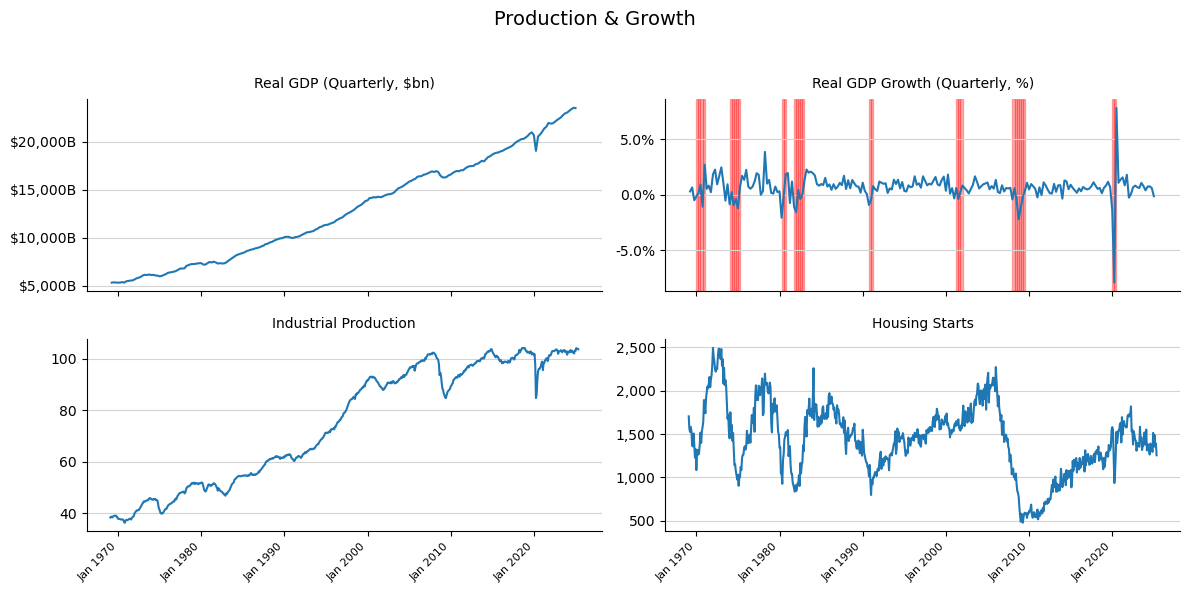

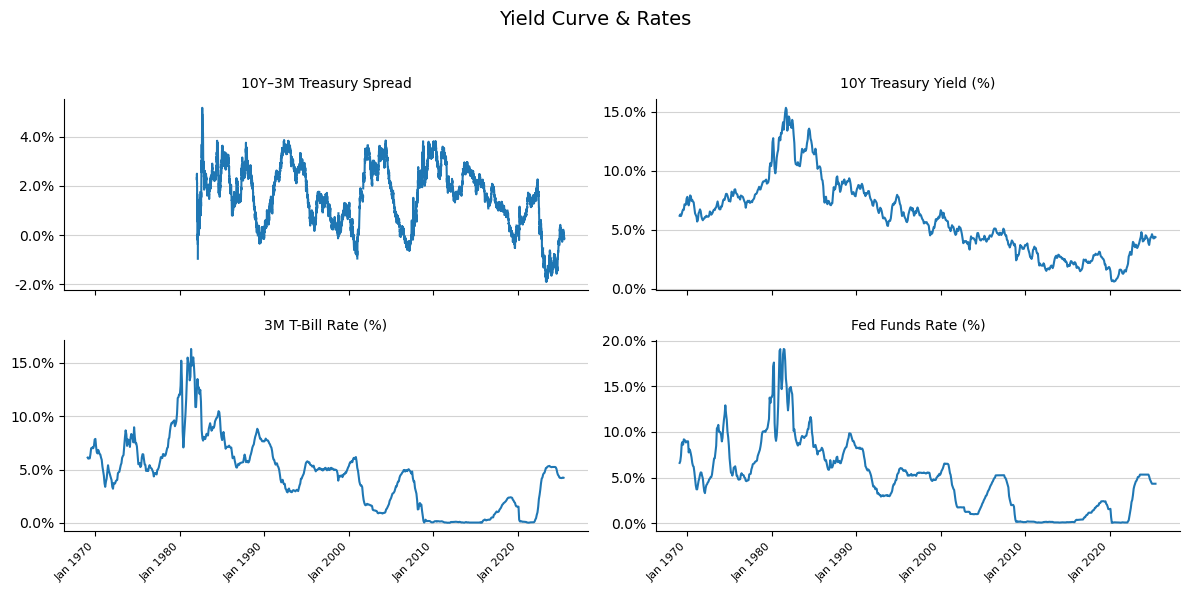

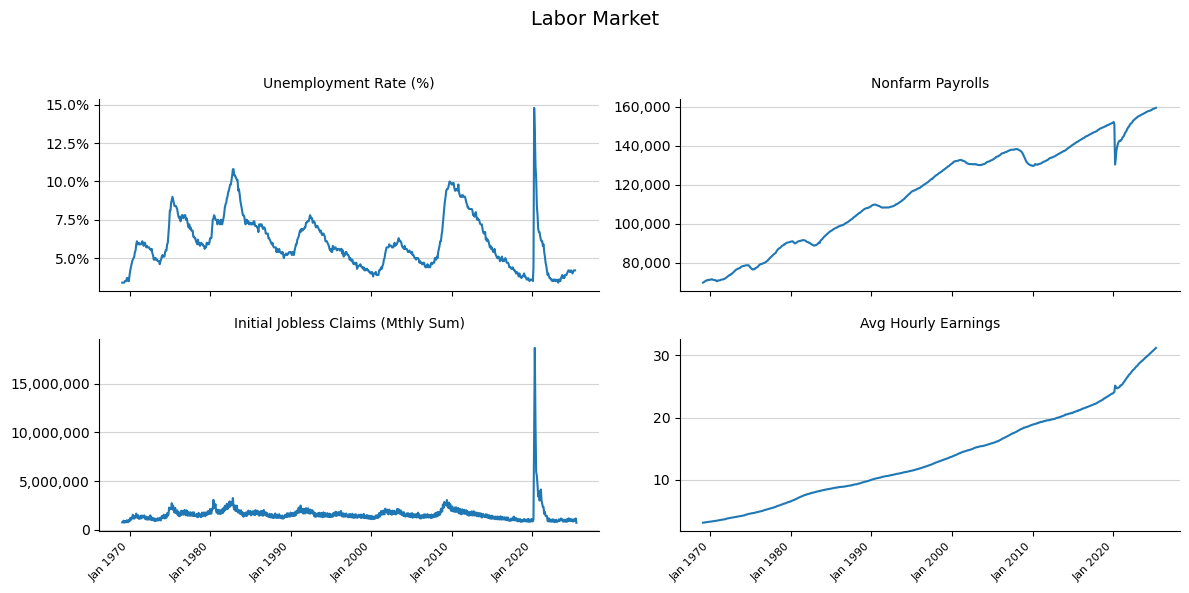

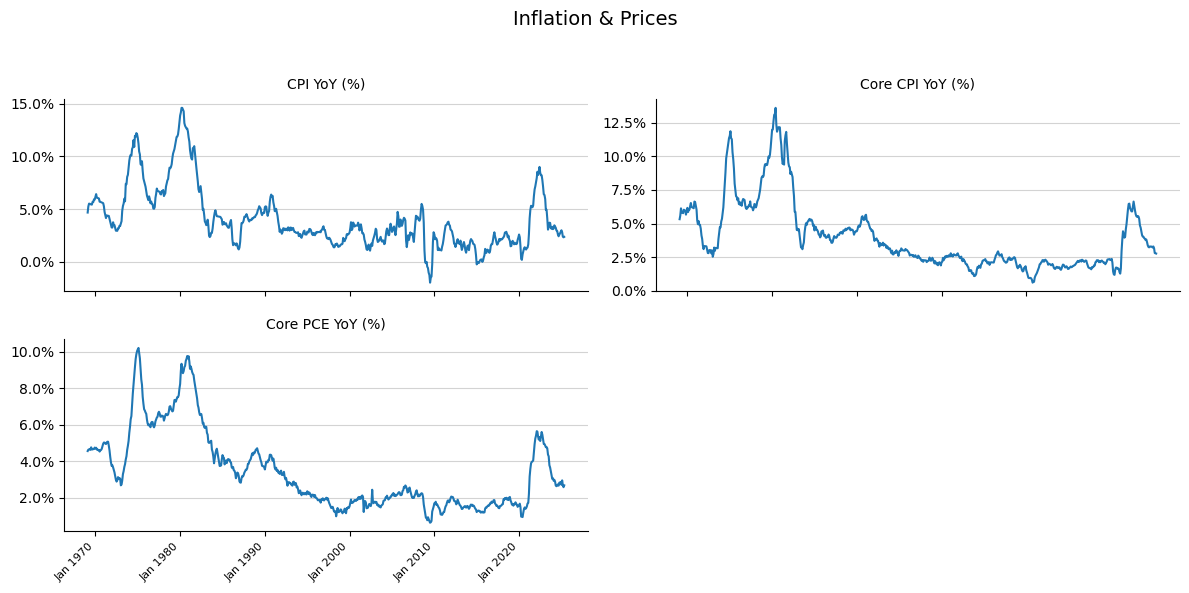

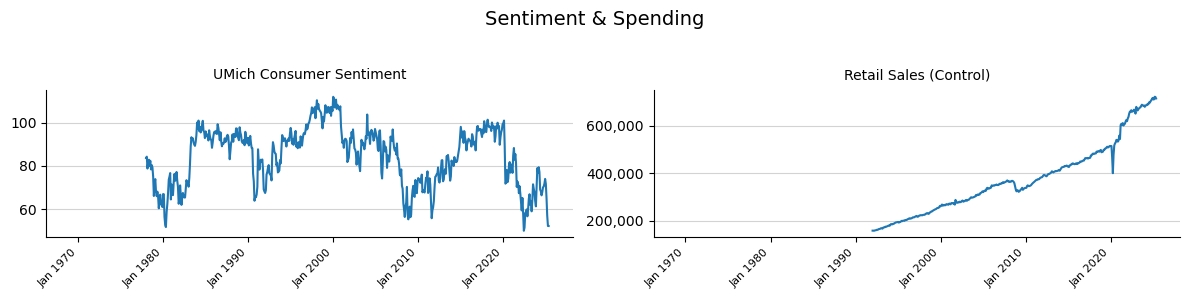

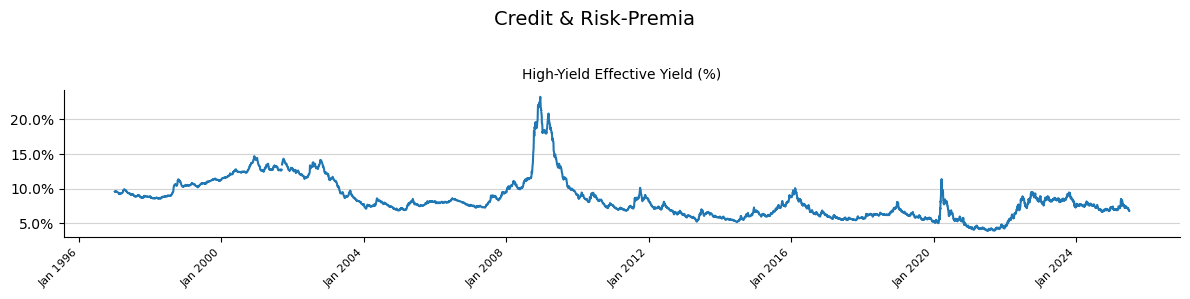

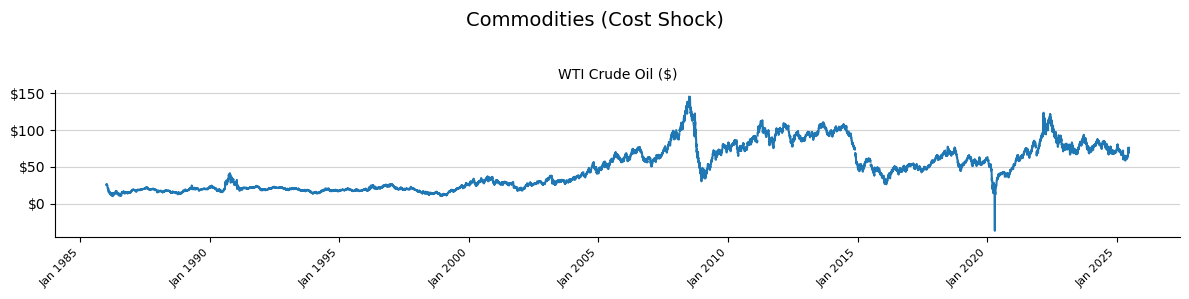

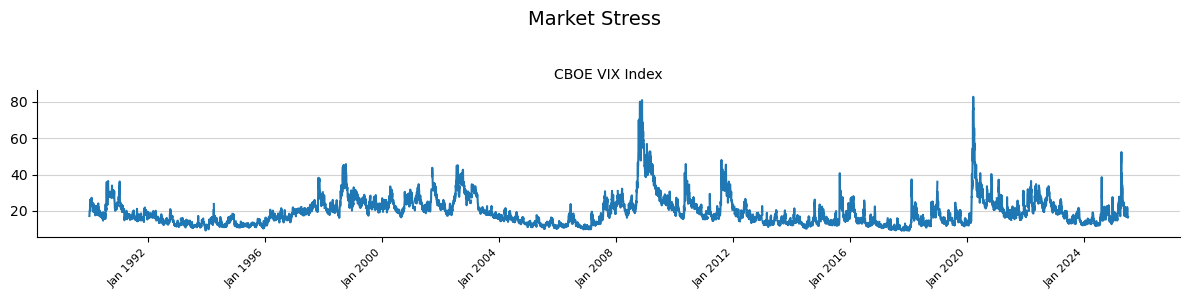

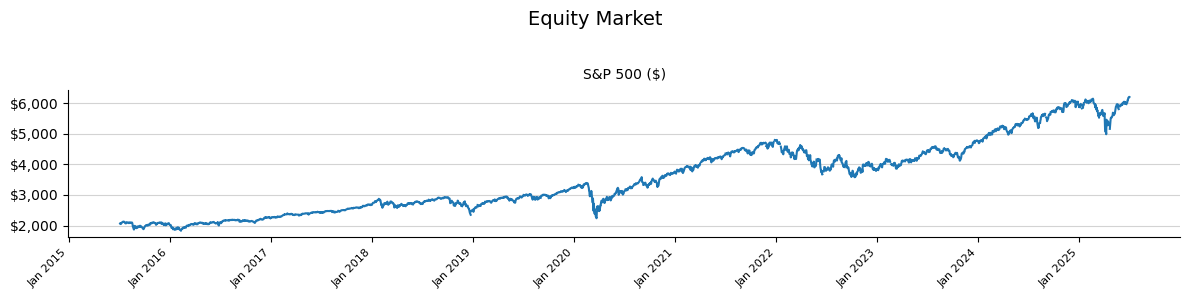

In [5]:
# --- compute recession spans ---
recession_quarters = series_dict['USRECQ'][series_dict['USRECQ'] == 1].index.to_period('Q')
recession_spans = [
    (rq.to_timestamp(), (rq + 1).to_timestamp())
    for rq in recession_quarters
]

# --- plot each group, but shade only GDPC1 ---
for grp_name, sids in groups.items():
    n = len(sids)
    cols = 2 if n > 1 else 1
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows), sharex=True)
    axes = axes.flatten() if n > 1 else [axes]

    for ax, sid in zip(axes, sids):
        ts = series_dict.get(sid)
        if ts is None or ts.empty:
            ax.set_title(f"{labels.get(sid, sid)}\n(no data)", fontsize=16)
            continue

        # Shade recessions only for GDPC1
        if sid == 'GDPC1_GROWTH':
            for start, end in recession_spans:
                ax.axvspan(start, end, color='red', alpha=0.3)

        ax.plot(ts.index, ts.values, linewidth=1.5)
        ax.set_title(labels[sid], fontsize=10, pad=8)
        ax.grid(axis='y', color='lightgrey', linewidth=0.8)

        # X-axis formatting
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

        # Y-axis formatting
        lbl = labels[sid]
        if '%' in lbl or 'Yield' in lbl or 'Spread' in lbl:
            fmt = lambda x, _: f"{x:.1f}%"
        elif '$bn' in lbl:
            fmt = lambda x, _: f"${x:,.0f}B"
        elif '$' in lbl:
            fmt = lambda x, _: f"${x:,.0f}"
        else:
            fmt = lambda x, _: f"{x:,.0f}"
        ax.yaxis.set_major_formatter(plt.FuncFormatter(fmt))

        # Clean spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Turn off any extra subplots
    for ax in axes[n:]:
        ax.axis('off')

    # Title and layout adjustments
    fig.suptitle(grp_name, fontsize=14, y=0.98)
    fig.tight_layout(rect=[0, 0, 1, 0.95], h_pad=1.5, w_pad=1.0)
    plt.show()


In [6]:
df1.Date = pd.to_datetime(df1.Date)

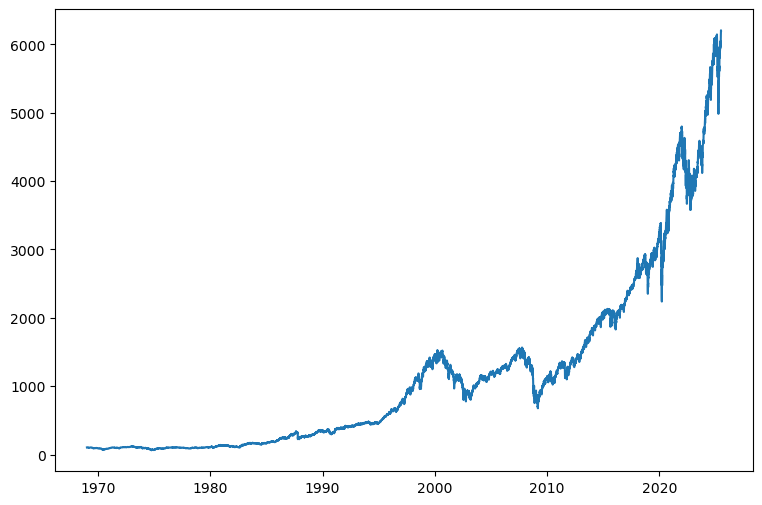

In [7]:
fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(df1.Date, df1.Close)